In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzbuilder_analysis.rendering as rg
import gzbuilder_analysis.fitting as fg
import gzbuilder_analysis.parsing as pg
import gzbuilder_analysis.config as cfg
try:
    from gzbuilder_analysis.rendering.cuda import calculate_model, oversampled_sersic_component
except ModuleNotFoundError:
    from gzbuilder_analysis.rendering import calculate_model, oversampled_sersic_component
from gzbuilder_analysis.fitting import Model, fit_model
from PIL import Image
import argparse
from asinh_cmap import asinh_cmap

In [3]:
fitting_metadata = pd.read_pickle('lib/fitting_metadata.pkl')
models = pd.read_pickle('lib/models.pickle')

In [4]:
subject_id = 21686555

In [5]:
fm = fitting_metadata.loc[subject_id]
data = fm['galaxy_data']
sigma_image = fm['sigma_image']
psf = fm['psf']

In [6]:
model = models.loc[subject_id]['best_individual']
tuned_model = models.loc[subject_id]['tuned_best_individual']
agg_model = models.loc[subject_id]['aggregate']
tuned_agg_model = models.loc[subject_id]['tuned_aggregate']

In [7]:
extent = (np.array([[-1, -1],[1, 1]]) * data.shape).T.ravel() / 2 * 0.396
imshow_kwargs = {
    'cmap': asinh_cmap, 'origin': 'lower',
    'extent': extent
}

In [8]:
m = Model(
    model,
    data,
    psf=psf,
    sigma_image=sigma_image
)
m_tuned = Model(
    tuned_model,
    data,
    psf=psf,
    sigma_image=sigma_image
)

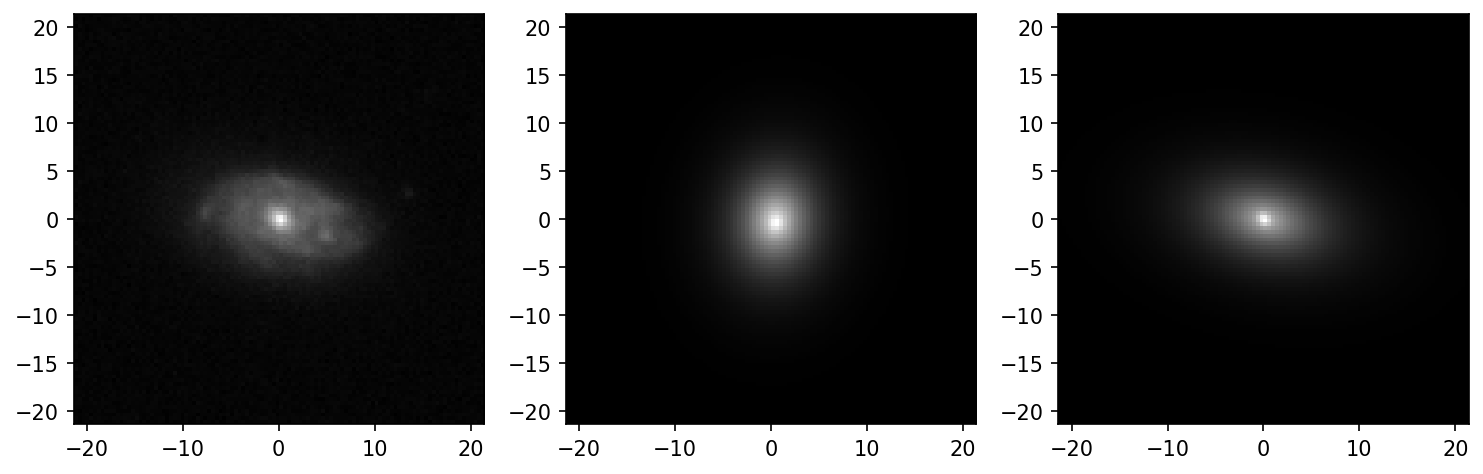

In [9]:
plt.figure(figsize=(12, 4), dpi=150)
plt.subplot(131)
plt.imshow(data, **imshow_kwargs)
plt.subplot(132)
plt.imshow(m.render(), **imshow_kwargs)
plt.subplot(133)
plt.imshow(m_tuned.render(), **imshow_kwargs)

In [10]:
m_agg = Model(
    agg_model,
    data,
    psf=psf,
    sigma_image=sigma_image
)
m_agg_tuned = Model(
    tuned_agg_model,
    data,
    psf=psf,
    sigma_image=sigma_image
)

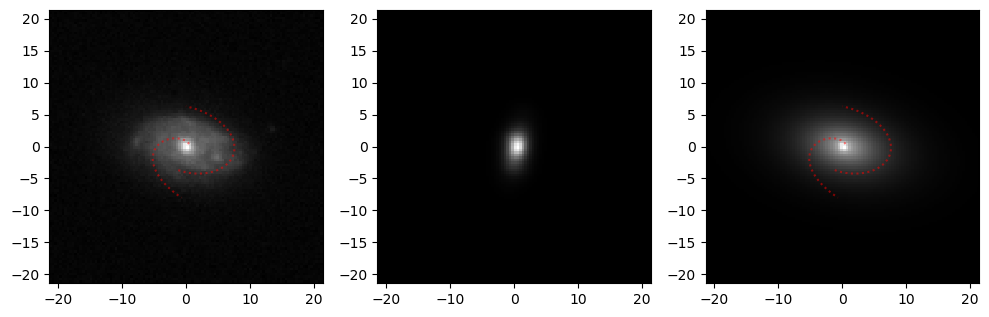

In [14]:
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(131)
plt.imshow(data, **imshow_kwargs)
for points, params in tuned_agg_model['spiral']:
    plt.plot(*(points - np.array(data.shape) / 2).T*0.396, 'r:', alpha=0.5)
plt.subplot(132)
plt.imshow(m_agg.render(), **imshow_kwargs)
plt.subplot(133)
plt.imshow(m_agg_tuned.render(), **imshow_kwargs)
for points, params in tuned_agg_model['spiral']:
    plt.plot(*(points - np.array(data.shape) / 2).T*0.396, 'r:', alpha=0.5)

What do the parameters look like?

In [12]:
pd.concat(
    (
        m.params.rename('raw BI').dropna(), m_tuned.params.rename('tuned BI').dropna(),
        m_agg.params.rename('Agg').dropna(), m_agg_tuned.params.rename('tuned Agg').dropna()
    ),
    axis=1
).T

component     bulge                                                           \
parameter         I        Re    c        mux        muy         n         q   
raw BI     0.312500  1.057310  2.0  54.714426  52.363411  1.000000  0.500120   
tuned BI   5.119625  0.472397  2.0  53.603666  53.394341  0.389154  0.428889   
Agg        0.200000  0.983796  2.0  54.947456  52.799751  1.000000  0.914873   
tuned Agg  6.408705  0.483823  2.0  53.601976  53.382303  0.200001  0.378372   

component                disk             ...                            \
parameter      roll         I         Re  ...        muy    n         q   
raw BI     2.872277  0.118750  13.142075  ...  52.996214  1.0  0.811769   
tuned BI   0.703012  0.129092  17.861680  ...  53.393903  1.0  0.587139   
Agg        2.461588  0.200000   5.725258  ...  52.879508  1.0  0.549239   
tuned Agg  0.631932  0.129089  17.861537  ...  53.393938  1.0  0.587180   

component           spiral0                      spiral1                   
parameter      roll       I  falloff    spread         I   falloff spread  
raw BI    -0.100393     NaN      NaN       NaN       NaN       NaN    NaN  
tuned BI   1.373798     NaN      NaN       NaN       NaN       NaN    NaN  
Agg        2.948796     0.1  1.00000  0.500000  0.100000  1.000000    0.5  
tuned Agg  1.373840     0.0  1.19685  0.492513  1.170549  1.747411    0.0  

[4 rows x 22 columns]